<a href="https://colab.research.google.com/github/alexc957/Tensorflow-2-Practice/blob/Practice/Cats_vs_Dogs_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import the libraries and download the pretrained model


In [2]:
import os 
from tensorflow.keras import layers 
from tensorflow.keras import Model 

### download the model 
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3  
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


## load the pretrained model 
pre_trained_model =  InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

## make all the layers to be non-trainable 
for layer in pre_trained_model.layers:
  layer.trainable = False 

### check the model by printing the summary 

pre_trained_model.summary()

--2020-10-23 15:30:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.217.7.176, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   221MB/s    in 0.4s    

2020-10-23 15:30:44 (221 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                     

#### add trainable layers to the model as follow:
- a flatten layer
- a fully conected layer of 1024 units 
- Dropout the 20% of the layers during training 
- add final layer to predict 

In [4]:
from tensorflow.keras.optimizers import RMSprop
last_output = pre_trained_model.get_layer('mixed7').output
# flatten the last layer to 1 dimension 
x = layers.Flatten()(last_output)
# add a fully conected layer
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)
# add a sigmoid layer for classification 
x = layers.Dense(1,activation='sigmoid')(x)

# instanciate the model 
model = Model(pre_trained_model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
              )

### get the data and create image generators 

In [5]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os 
import zipfile 

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150)) 


# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-10-23 15:41:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.217.15.80, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  55.8MB/s    in 1.2s    

2020-10-23 15:41:24 (55.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Train the model 

In [7]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 20s 202ms/step - loss: 0.2301 - accuracy: 0.9095 - val_loss: 0.0932 - val_accuracy: 0.9640
Epoch 2/20
100/100 [==============================] - 20s 201ms/step - loss: 0.1844 - accuracy: 0.9310 - val_loss: 0.1143 - val_accuracy: 0.9580
Epoch 3/20
100/100 [==============================] - 20s 201ms/step - loss: 0.1986 - accuracy: 0.9305 - val_loss: 0.1142 - val_accuracy: 0.9620
Epoch 4/20
100/100 [==============================] - 20s 202ms/step - loss: 0.2204 - accuracy: 0.9235 - val_loss: 0.1072 - val_accuracy: 0.9640
Epoch 5/20
100/100 [==============================] - 20s 203ms/step - loss: 0.1788 - accuracy: 0.9350 - val_loss: 0.1974 - val_accuracy: 0.9430
Epoch 6/20
100/100 [==============================] - 20s 203ms/step - loss: 0.1775 - accuracy: 0.9435 - val_loss: 0.1116 - val_accuracy: 0.9650
Epoch 7/20
100/100 [==============================] - 20s 204ms/step - loss: 0.1822 - accuracy: 0.9390 - val_loss: 0.1169 - val_ac

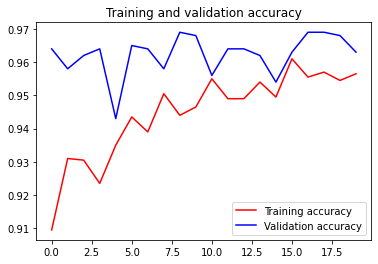

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()